# AML Homework 1

### Author: Yelene Cisse
### Date: 10/03/2025
### Data: https://archive.ics.uci.edu/dataset/45/heart+disease
### Purpose:  

Predict whether a patient has heart disease based on medical attributes.

# Set up
Define useful functions.
Import necessary libraries and dataset.

In [888]:
# Import libraries

# For data manipulations
import pandas as pd
import numpy as np

# For feature engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# For model training
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_curve, auc, precision_recall_curve
)

# For visualization
import seaborn as sns
from seaborn import heatmap
from matplotlib import pyplot as plt

# For data import:
from ucimlrepo import fetch_ucirepo
pd.set_option('display.max_columns', None)

In [889]:
# For data exploration
def data_summary(df, cat_cols, num_cols, describe_pts=[0.1, .2,.25,.5, .75, .9, .95, .99]):
    print("Data shape: ", df.shape)
    print("Data columns: ", df.columns)

    # Get hit rates for variables in the dataset, evaluate missing values proportions
    hr = df.notnull().mean().reset_index().rename(columns={'index':'variable',0:'hit_rate'}) 

    # Get data types
    df_types = df.dtypes.reset_index().rename(columns={'index':'variable',0:'data_type'}) 

    # Put info in same data add
    variable_summary = pd.merge(df_types, hr, on=['variable'], how='left', suffixes=('','_hr'))

    # Get value counts for categorical variables
    cat_vars_summary = pd.DataFrame(columns=['variable_name','unique_values','counts'])
    for col in cat_cols:
        new_counts = df[col].value_counts(dropna=False).rename_axis('unique_values').to_frame('counts').reset_index()
        new_counts.insert(loc=0, column='variable_name', value=col)
        cat_vars_summary = pd.concat([cat_vars_summary, new_counts], ignore_index = True)
        
    cont_vars_summary = df[num_cols].describe(describe_pts).reset_index().rename(columns={'index':'stats'}) 

    # Get correlation matrix for continuous variables
    df_corr = df[num_cols].corr()

    return variable_summary, cat_vars_summary, cont_vars_summary, df_corr

# The following function were taken from class Colab examples
def pos_ratio(a):
    return float(a.mean())

# For model evaluation
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm, interpolation='nearest')
    # plt.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks); ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticks(tick_marks); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    ax.set_ylabel('True label'); ax.set_xlabel('Predicted label')
    plt.colorbar(im)
    plt.tight_layout(); plt.show()


In [890]:
# Import dataset - Code directly taken from the source website

# fetch dataset 
heart_disease = fetch_ucirepo(id=45)

df = heart_disease.data.original
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

# Data Cleaning

Data Complete Dictionary from UCI website:

age
sex: sex (1 = male; 0 = female)
cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
trestbps: resting blood pressure (in mm Hg on admission to the hospital)
chol: serum cholestoral in mg/dl
fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
restecg: resting electrocardiographic results - ordinal
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach: maximum heart rate achieved
exang: exercise induced angina (1 = yes; 0 = no)
oldpeak = ST depression induced by exercise relative to rest (Exercise-induced ST depression is a reliable sign of obstructive coronary artery disease, which means there are blockages in the heart's arteries.)
slope: the slope of the peak exercise ST segment - ordinal
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
ca: number of major vessels (0-3) colored by flourosopy
thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)

In [891]:
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [892]:
# Create categorical and continuous lists
cat =  heart_disease.variables[heart_disease.variables['type']=="Categorical"]['name'].to_list()

# Based on variable dictionary, create different lists for binary and non binary variables
# We will use this distinction later for encoding
binary_cat = ['sex','fbs', 'exang']
non_binary_cat = [i for i in cat if i not in binary_cat]

cont =  heart_disease.variables[heart_disease.variables['type']=="Integer"]['name'].to_list()

print("Categorical features: " , cat, "\nContinuous features: ", cont)

Categorical features:  ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'] 
Continuous features:  ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'num']


Data exploration

In [893]:
# Get summary statistics
variable_summary, cat_vars_summary, cont_vars_summary, df_corr = data_summary(df, cat, cont)

Data shape:  (303, 14)
Data columns:  Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [894]:
variable_summary

# Hit rates are high within this dataset, only two variables with missing values, with less than 2% of the data missing.

,variable,data_type,hit_rate
0,age,int64,1.000000
1,sex,int64,1.000000
2,cp,int64,1.000000
3,trestbps,int64,1.000000
4,chol,int64,1.000000
5,fbs,int64,1.000000
6,restecg,int64,1.000000
7,thalach,int64,1.000000
8,exang,int64,1.000000
9,oldpeak,float64,1.000000


In [895]:
cat_vars_summary

# There is a good distribution of values among categories ( no variable dominated >95% + by one value), can keep all of them.

,variable_name,unique_values,counts
0,sex,1,206
1,sex,0,97
2,cp,4,144
3,cp,3,86
4,cp,2,50
5,cp,1,23
6,fbs,0,258
7,fbs,1,45
8,restecg,0,151
9,restecg,2,148


In [896]:
cont_vars_summary

# Looking at the 10th and 90th percentile, there does not seem to be major outliers in most variables.
# However, we will visualize the data before making any decision.

,stats,age,trestbps,chol,thalach,oldpeak,ca,num
0,count,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,303.000000
1,mean,54.438944,131.689769,246.693069,149.607261,1.039604,0.672241,0.937294
2,std,9.038662,17.599748,51.776918,22.875003,1.161075,0.937438,1.228536
3,min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
4,10%,42.000000,110.000000,188.800000,116.000000,0.000000,0.000000,0.000000
5,20%,45.000000,120.000000,204.000000,130.000000,0.000000,0.000000,0.000000
6,25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000
7,50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000,0.000000
8,75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,2.000000
9,90%,66.000000,152.000000,308.800000,176.600000,2.800000,2.000000,3.000000


In [897]:
df_corr

# Variables with most correlation to target are ca, oldpeak and thalach
# Variables in general not closely correlated

,age,trestbps,chol,thalach,oldpeak,ca,num
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.362605,0.222853
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.098773,0.157754
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.119000,0.070909
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.264246,-0.415040
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.295832,0.504092
ca,0.362605,0.098773,0.119000,-0.264246,0.295832,1.000000,0.518909
num,0.222853,0.157754,0.070909,-0.415040,0.504092,0.518909,1.000000


Visualize data before cleaning/transformations

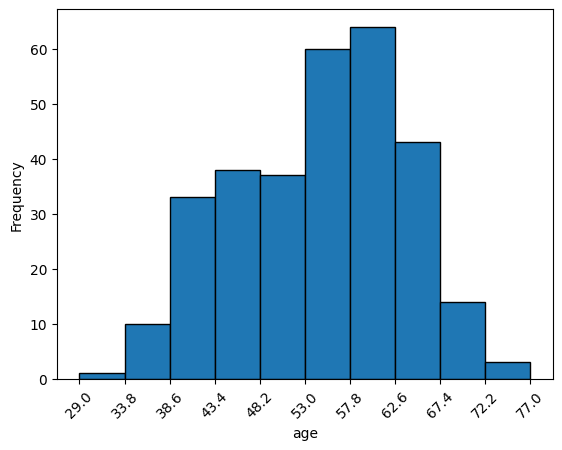

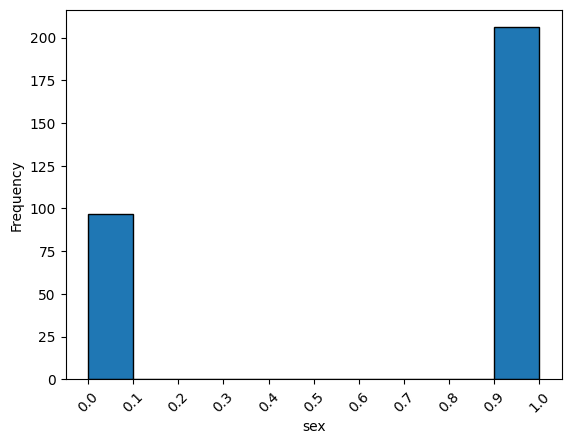

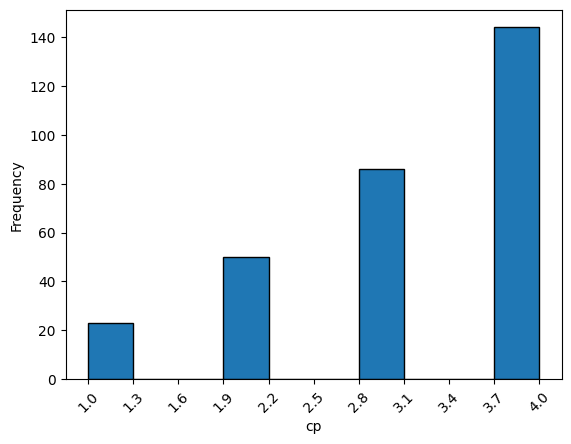

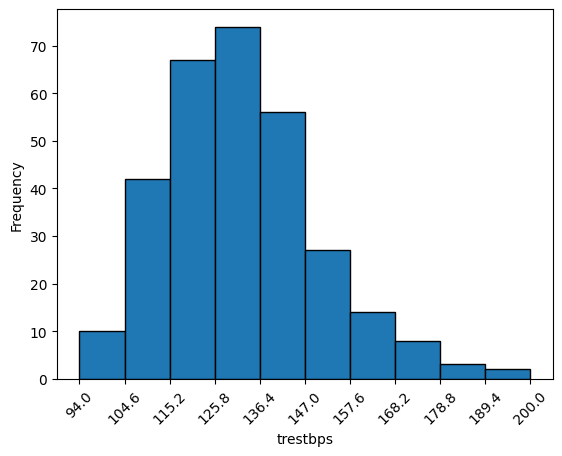

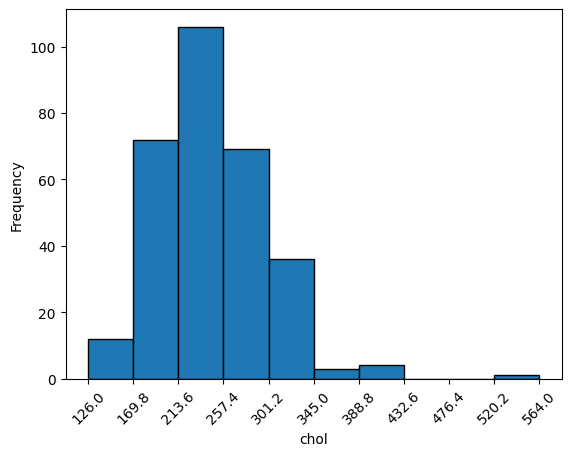

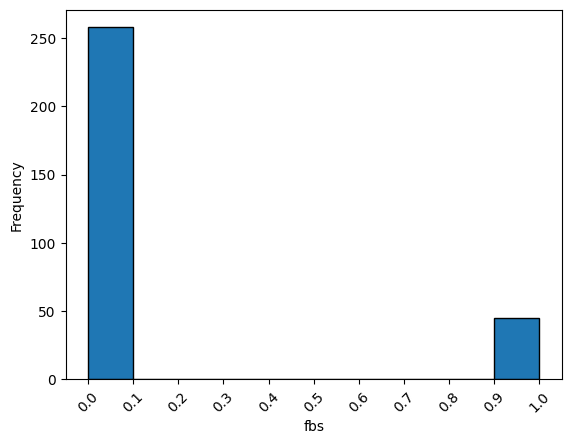

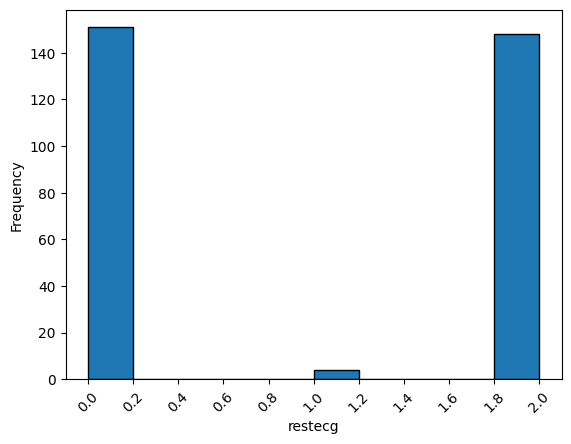

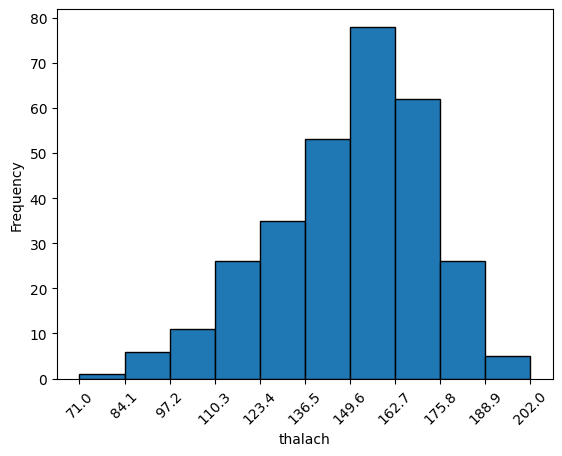

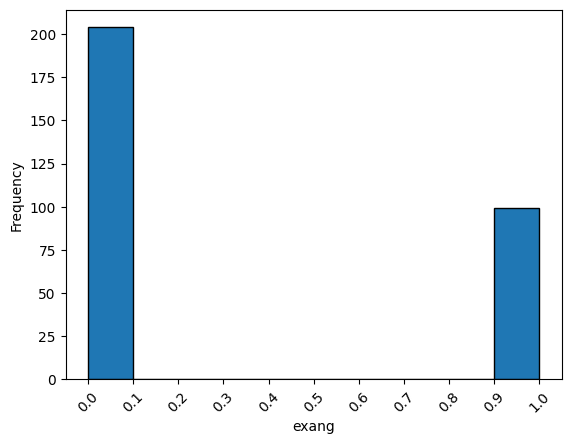

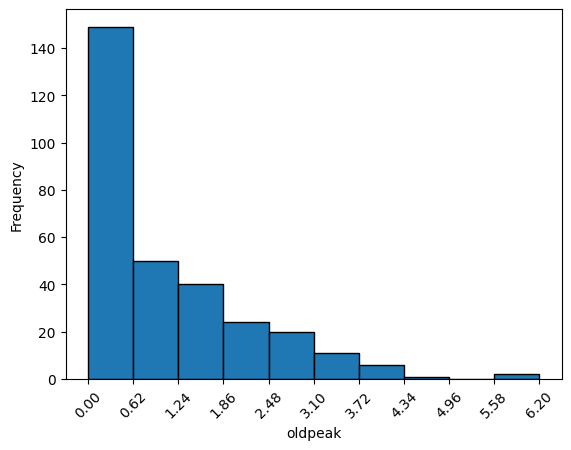

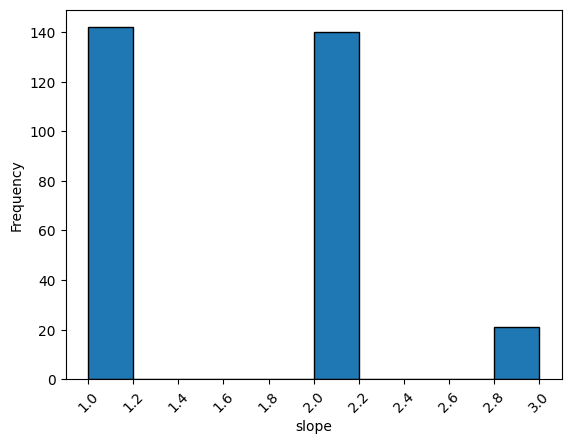

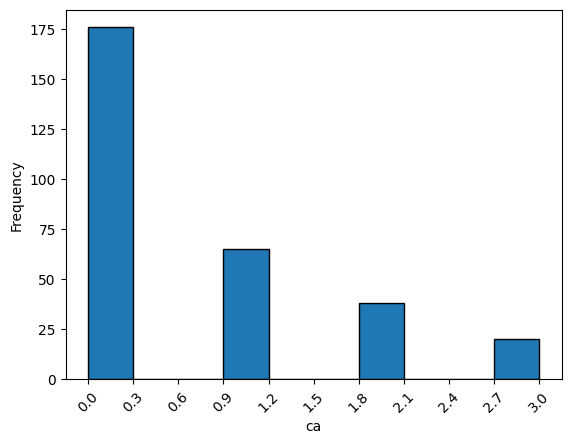

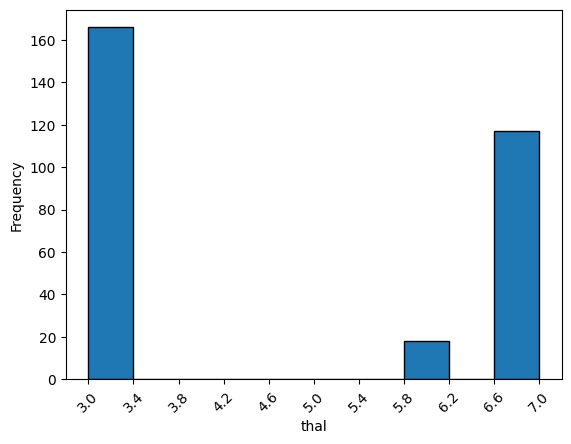

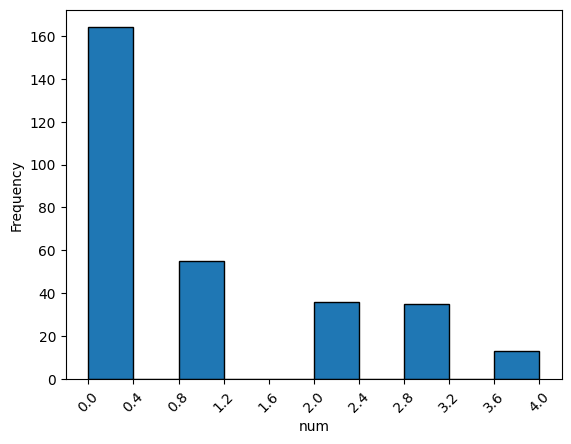

In [898]:
for var in df.columns:
    counts, bin_edges, _ = plt.hist(df[var], edgecolor='black')
    plt.xticks(bin_edges, rotation=45)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.fill()
    plt.show()

In [899]:
# After looking at the plots, cholesterol has outlier > 500 and oldpeak has outlier > 5

# check values
print(df[df['chol']>500]['chol'] , "\n" , df[df['oldpeak']>5]['oldpeak'])

152    564
Name: chol, dtype: int64 
 91     6.2
123    5.6
Name: oldpeak, dtype: float64


In [900]:
# We will cap these variables to avoid disturbance in the models, use max value after lowest val of the outlier
df.loc[df['chol']>500, 'chol'] = df[df['chol']<500]['chol'].max()
df.loc[df['oldpeak']>5, 'oldpeak'] = df[df['oldpeak']<5]['oldpeak'].max()

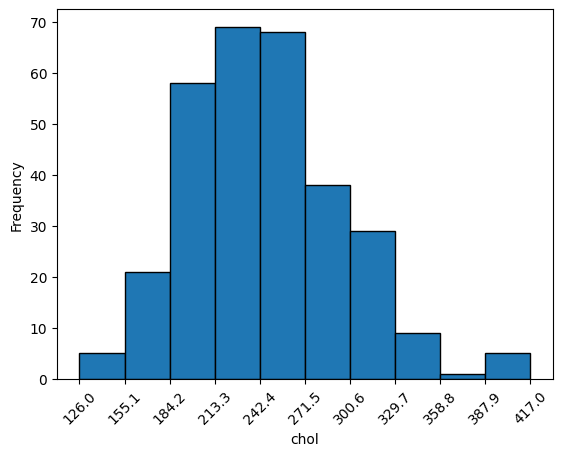

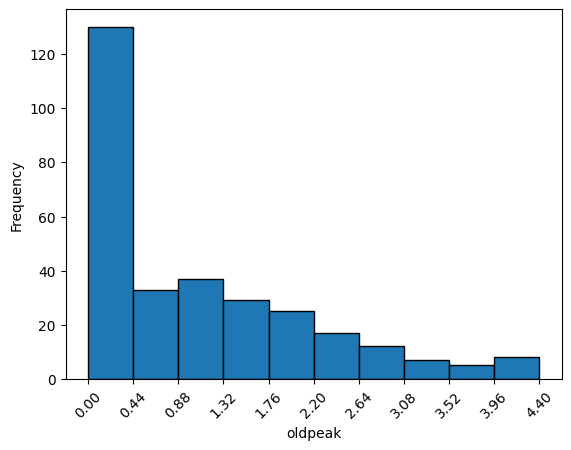

In [901]:
# Verify changes
for var in ['chol','oldpeak']:
    counts, bin_edges, _ = plt.hist(df[var], edgecolor='black')
    plt.xticks(bin_edges, rotation=45)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.fill()
    plt.show()

# chol could be grouped further but we will keep this level of granularity to avoid information loss

Missing variables handling

In [902]:
# Check columns with missing value
df[df['ca'].isna()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


In [903]:
df[df['thal'].isna()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,2


In [904]:
# Since thal is amongst the categorical variables, we will fill with -1 instead of dropping to avoid loss of information in other columns
df['thal'] = df['thal'].fillna(-1)

# Create a missing indicator for continuous variable
df['ca_miss_ind'] = np.where(df['ca'].isna(), 1, 0)

# Mean impute ca as this is a numerical variable
# Since the median and mode is 0, we will use 0 as imputation value
df['ca'].fillna(0, inplace=True)

print(df.shape)

(303, 15)


In [905]:
# Change target to binary, we are only interested in whether the heart didease is present or not.
# "Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0)"
print(df['num'].value_counts())
df['num'] = np.where(df['num']>0, 1, 0 )
print(df['num'].value_counts())

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64
num
0    164
1    139
Name: count, dtype: int64


# Feature engineering

Feature creation

In [906]:
# Blood pressure categories
# Normal blood pressure is less than 120/80 mm Hg ; High blood pressure is consistently at or above 130/80 mm Hg (Source: CDC, https://www.cdc.gov/high-blood-pressure/about/index.html)
# We will let 0 = normal bp and 1 = high bp
df['trestbps_category'] = np.where(df['trestbps']>130, 1, 0)

# Add this to binary feature list
binary_cat.append('trestbps_category')

# Categorize age following Chronological age :
# Adulthood is usually divided into several periods: young or early adulthood (approximately aged 20–39), middle adulthood (40–59), and old age (60+). 
# Old age is typically divided into the periods of young old (60–75) and old old (75 and up). (Source: https://www.sciencedirect.com/topics/computer-science/chronological-age)
df['age_category'] = 'Young adulthood'
df.loc[df['age']>=40, 'age_category'] = 'Middle adulthood'
df.loc[df['age']>=60, 'age_category'] = 'Young old age'
df.loc[df['age']>=75, 'age_category'] = 'Old old age'

print(df['age_category'].value_counts())

# Cholesterol level grouping according to John Hopkins - (Source: https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/lipid-panel#:~:text=Normal:%20Less%20than%20150%20mg,14%20hours%20before%20this%20test.)
# Given limited information on cholesterol type, we will assume total cholesterol ranges for this exercise.
# Normal: Less than 200 mg/dL
# Borderline high: 200 to 239 mg/dL
# High: At or above 240 mg/dL

df['chol_category'] = 'Normal'
df.loc[df['chol']>=200, 'chol_category'] = 'Borderline high'
df.loc[df['chol']>=240, 'chol_category'] = 'High'

print(df['chol_category'].value_counts())

# We will use qcut binning for oldpeak and thalach.

# Since oldpeak is 50% 0s, we will start at .5 and increment by 10% to create 5 bins
df['oldpeak_category'] = pd.qcut(df['oldpeak'], q =[0, .5, .6, .7, .8, .9, 1])

# Create deciles for thalach
df['thalach_category'] = pd.qcut(df['thalach'], q =10)

print(df['oldpeak_category'].value_counts(), df['thalach_category'].value_counts())

# Update categorical list with new features

cat = cat + ['age_category', 'chol_category', 'oldpeak_category', 'thalach_category']
non_binary_cat = non_binary_cat + ['age_category', 'chol_category', 'oldpeak_category', 'thalach_category']


age_category
Middle adulthood    197
Young old age        89
Young adulthood      15
Old old age           2
Name: count, dtype: int64
chol_category
High               156
Borderline high     98
Normal              49
Name: count, dtype: int64
oldpeak_category
(-0.001, 0.8]    163
(1.9, 2.8]        33
(1.12, 1.4]       31
(1.4, 1.9]        31
(2.8, 4.4]        26
(0.8, 1.12]       19
Name: count, dtype: int64 thalach_category
(159.0, 163.0]     35
(70.999, 116.0]    32
(146.0, 153.0]     32
(116.0, 130.0]     31
(140.6, 146.0]     31
(176.6, 202.0]     31
(153.0, 159.0]     30
(130.0, 140.6]     28
(163.0, 170.0]     27
(170.0, 176.6]     26
Name: count, dtype: int64


One hot-encoding

In [907]:
# Bernoulli Transformations

# One hot-encoding on categorical variables
encoded_var_list = []

# The code below is adapted from the "AML_L2_Colab_Demos.ipynb" code example
for var in non_binary_cat:
    print('Variable to encode: ', var)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    var_ohe = ohe.fit_transform(df[[var]])

    print("One-hot categories:", ohe.categories_)
    print("Encoded shape:", var_ohe.shape)
    encoded_var = pd.DataFrame(var_ohe, columns=[f"{var}={c}" for c in ohe.categories_[0]])
    encoded_var_list = encoded_var_list + list(encoded_var.columns)
    df = pd.merge(df, encoded_var, left_index=True, right_index=True, how='left', suffixes=('','_encod_var'))
    print(df.shape)

Variable to encode:  cp
One-hot categories: [array([1, 2, 3, 4])]
Encoded shape: (303, 4)
(303, 24)
Variable to encode:  restecg
One-hot categories: [array([0, 1, 2])]
Encoded shape: (303, 3)
(303, 27)
Variable to encode:  slope
One-hot categories: [array([1, 2, 3])]
Encoded shape: (303, 3)
(303, 30)
Variable to encode:  thal
One-hot categories: [array([-1.,  3.,  6.,  7.])]
Encoded shape: (303, 4)
(303, 34)
Variable to encode:  age_category
One-hot categories: [array(['Middle adulthood', 'Old old age', 'Young adulthood',
       'Young old age'], dtype=object)]
Encoded shape: (303, 4)
(303, 38)
Variable to encode:  chol_category
One-hot categories: [array(['Borderline high', 'High', 'Normal'], dtype=object)]
Encoded shape: (303, 3)
(303, 41)
Variable to encode:  oldpeak_category
One-hot categories: [array([Interval(-0.001, 0.8, closed='right'),
       Interval(0.8, 1.12, closed='right'),
       Interval(1.12, 1.4, closed='right'),
       Interval(1.4, 1.9, closed='right'),
       Inter

In [908]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,ca_miss_ind,trestbps_category,age_category,chol_category,oldpeak_category,thalach_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Old old age,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=(-0.001, 0.8]","oldpeak_category=(0.8, 1.12]","oldpeak_category=(1.12, 1.4]","oldpeak_category=(1.4, 1.9]","oldpeak_category=(1.9, 2.8]","oldpeak_category=(2.8, 4.4]","thalach_category=(70.999, 116.0]","thalach_category=(116.0, 130.0]","thalach_category=(130.0, 140.6]","thalach_category=(140.6, 146.0]","thalach_category=(146.0, 153.0]","thalach_category=(153.0, 159.0]","thalach_category=(159.0, 163.0]","thalach_category=(163.0, 170.0]","thalach_category=(170.0, 176.6]","thalach_category=(176.6, 202.0]"
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0,1,Young old age,Borderline high,"(1.9, 2.8]","(146.0, 153.0]",1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1,0,1,Young old age,High,"(1.4, 1.9]","(70.999, 116.0]",0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,0,0,Young old age,Borderline high,"(1.9, 2.8]","(116.0, 130.0]",0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0,0,Young adulthood,High,"(2.8, 4.4]","(176.6, 202.0]",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0,0,Middle adulthood,Borderline high,"(1.12, 1.4]","(170.0, 176.6]",0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1,0,0,Middle adulthood,High,"(1.12, 1.4]","(130.0, 140.6]",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,1,0,1,Young old age,Normal,"(2.8, 4.4]","(140.6, 146.0]",0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1,0,0,Middle adulthood,Normal,"(1.12, 1.4]","(70.999, 116.0]",0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,0,0,Middle adulthood,Borderline high,"(-0.001, 0.8]","(170.0, 176.6]",0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Standardization

In [909]:
# Standardize continuous data for model
# The code below is adapted from the "AML_L2_Colab_Demos.ipynb" example
scaler = StandardScaler()
std = scaler.fit_transform(df[cont])
standardized_df = pd.DataFrame(std, columns=cont)

# Rename axis before merging normalized variables with data
rename_dict = dict(zip(cont, [i+"_std" for i in cont]))
standardized_df.rename(columns=rename_dict, inplace=True)
# Remove target standardized values
standardized_df.drop(['num_std'], inplace=True, axis=1)
standardized_df

,age_std,trestbps_std,chol_std,thalach_std,oldpeak_std,ca_std
0,0.948726,0.757525,-0.267650,0.017197,1.130971,-0.711131
1,1.392002,1.611220,0.806360,-1.821905,0.418715,2.504881
2,1.392002,-0.665300,-0.348707,-0.902354,1.398067,1.432877
3,-1.932564,-0.096170,0.076844,1.637359,2.199354,-0.711131
4,-1.489288,-0.096170,-0.855316,0.980537,0.329683,-0.711131
...,...,...,...,...,...,...
298,-1.046013,-1.234430,0.360545,-0.770990,0.151619,-0.711131
299,1.502821,0.700612,-1.078224,-0.376896,2.110322,1.432877
300,0.283813,-0.096170,-2.334613,-1.515388,0.151619,0.360873
301,0.283813,-0.096170,-0.206857,1.068113,-0.916765,0.360873


In [910]:
# Add standardize variables to the data
df = pd.merge(df, standardized_df, left_index=True, right_index=True, how='left', suffixes=('','_std_var'))
print(df.shape)
df.head()

(303, 63)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,ca_miss_ind,trestbps_category,age_category,chol_category,oldpeak_category,thalach_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Old old age,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=(-0.001, 0.8]","oldpeak_category=(0.8, 1.12]","oldpeak_category=(1.12, 1.4]","oldpeak_category=(1.4, 1.9]","oldpeak_category=(1.9, 2.8]","oldpeak_category=(2.8, 4.4]","thalach_category=(70.999, 116.0]","thalach_category=(116.0, 130.0]","thalach_category=(130.0, 140.6]","thalach_category=(140.6, 146.0]","thalach_category=(146.0, 153.0]","thalach_category=(153.0, 159.0]","thalach_category=(159.0, 163.0]","thalach_category=(163.0, 170.0]","thalach_category=(170.0, 176.6]","thalach_category=(176.6, 202.0]",age_std,trestbps_std,chol_std,thalach_std,oldpeak_std,ca_std
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0,1,Young old age,Borderline high,"(1.9, 2.8]","(146.0, 153.0]",1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.948726,0.757525,-0.267650,0.017197,1.130971,-0.711131
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1,0,1,Young old age,High,"(1.4, 1.9]","(70.999, 116.0]",0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.392002,1.611220,0.806360,-1.821905,0.418715,2.504881
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,0,0,Young old age,Borderline high,"(1.9, 2.8]","(116.0, 130.0]",0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.392002,-0.665300,-0.348707,-0.902354,1.398067,1.432877
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0,0,Young adulthood,High,"(2.8, 4.4]","(176.6, 202.0]",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.932564,-0.096170,0.076844,1.637359,2.199354,-0.711131
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0,0,Middle adulthood,Borderline high,"(1.12, 1.4]","(170.0, 176.6]",0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.489288,-0.096170,-0.855316,0.980537,0.329683,-0.711131


In [911]:
# Keep a copy of the full data - could save for future model runs and monitoring.
df_fe = df.copy()
df = df_fe.copy()

# Model Training

Train test split

In [913]:
# Split the data into training, test and validation
# We wil do an 70 - 30 split

# Select all items but target
X = df[[i for i in df.columns if i!='num']]
# Create target df
y = df[['num']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)

for df in [X_train, X_test, y_train, y_test ]:
    print('Data shape: ', df.shape)

# Set up parameters for model runs

# Laplace smoothing parameters
alphasNB = {'alpha = 1':1, 'alpha = 0.01':0.01}

# Regression: Lasso - shrink coefficients to 0 ; Ridge - shrink coefficients equally
alphasLR = { 'Regular LR':"n/a", 'Lasso':1e-10, 'Ridge':1}

# Change y to nd array for model - warning when running without
y_train, y_test = np.array(y_train['num']), np.array(y_test['num'])

Data shape:  (212, 62)
Data shape:  (91, 62)
Data shape:  (212, 1)
Data shape:  (91, 1)


/var/folders/3g/b4zyzzk94gz7cbv03g735r2m0000gn/T/ipykernel_58682/3612712420.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(a.mean())


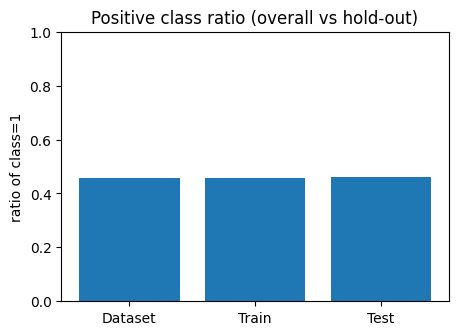

Overall: 0.459 | Train: 0.458 | Test: 0.462


In [914]:
# Make sure we get same ratio with stratified data
labels = ['Dataset', 'Train', 'Test']
ratios = [pos_ratio(y), pos_ratio(y_train), pos_ratio(y_test)]

plt.figure(figsize=(5,3.5))
plt.bar(labels, ratios)
plt.ylim(0,1)
plt.title('Positive class ratio (overall vs hold-out)')
plt.ylabel('ratio of class=1')
plt.show()

print(f'Overall: {pos_ratio(y):.3f} | Train: {pos_ratio(y_train):.3f} | Test: {pos_ratio(y_test):.3f}')


## a. Naive Bayes

We will test two models: BernoulliNB for categorical features and GaussianNB for continuous

We will also test all features with each model and evaluate the best one for comparison witht the linear regression.

### Run BernoulliNB

In [915]:
# Create the BernoulliNB X datasets with categorical vars

included_vars = binary_cat + encoded_var_list

# To update after reviewing results
exclude_vars = []

X_train_bernNB = X_train[[i for i in included_vars if i not in exclude_vars]] 
X_test_bernNB = X_test[[i for i in included_vars if i not in exclude_vars]] 

print(X_train_bernNB.columns, X_train_bernNB.shape)
X_train_bernNB.head()

Index(['sex', 'fbs', 'exang', 'trestbps_category', 'cp=1', 'cp=2', 'cp=3',
       'cp=4', 'restecg=0', 'restecg=1', 'restecg=2', 'slope=1', 'slope=2',
       'slope=3', 'thal=-1.0', 'thal=3.0', 'thal=6.0', 'thal=7.0',
       'age_category=Middle adulthood', 'age_category=Old old age',
       'age_category=Young adulthood', 'age_category=Young old age',
       'chol_category=Borderline high', 'chol_category=High',
       'chol_category=Normal', 'oldpeak_category=(-0.001, 0.8]',
       'oldpeak_category=(0.8, 1.12]', 'oldpeak_category=(1.12, 1.4]',
       'oldpeak_category=(1.4, 1.9]', 'oldpeak_category=(1.9, 2.8]',
       'oldpeak_category=(2.8, 4.4]', 'thalach_category=(70.999, 116.0]',
       'thalach_category=(116.0, 130.0]', 'thalach_category=(130.0, 140.6]',
       'thalach_category=(140.6, 146.0]', 'thalach_category=(146.0, 153.0]',
       'thalach_category=(153.0, 159.0]', 'thalach_category=(159.0, 163.0]',
       'thalach_category=(163.0, 170.0]', 'thalach_category=(170.0, 176.6

,sex,fbs,exang,trestbps_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Old old age,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=(-0.001, 0.8]","oldpeak_category=(0.8, 1.12]","oldpeak_category=(1.12, 1.4]","oldpeak_category=(1.4, 1.9]","oldpeak_category=(1.9, 2.8]","oldpeak_category=(2.8, 4.4]","thalach_category=(70.999, 116.0]","thalach_category=(116.0, 130.0]","thalach_category=(130.0, 140.6]","thalach_category=(140.6, 146.0]","thalach_category=(146.0, 153.0]","thalach_category=(153.0, 159.0]","thalach_category=(159.0, 163.0]","thalach_category=(163.0, 170.0]","thalach_category=(170.0, 176.6]","thalach_category=(176.6, 202.0]"
122,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
170,1,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


This is the alpha = 1 run.
Getting metrics...


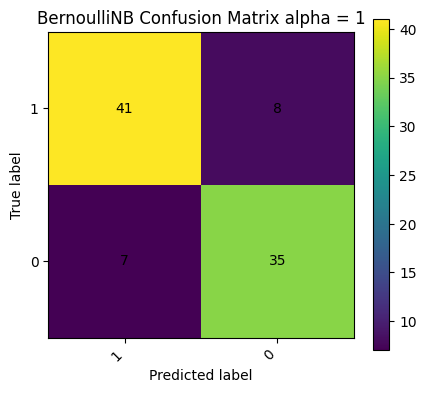

This is the alpha = 0.01 run.
Getting metrics...


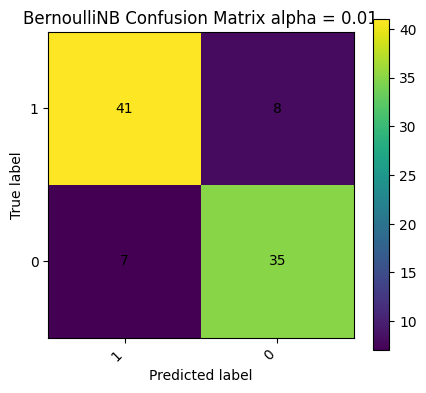

In [916]:
# Run model and get predictions

models_accuracy_scores = pd.DataFrame(columns=['model','alpha','accuracy'])
metrics_totals_summary = None
metrics_by_target_level_summary = None

for laplace, alpha in alphasNB.items():
    print("This is the " + laplace + " run.")
    bernNB = BernoulliNB(alpha=alpha)
    bernNB.fit(X_train_bernNB, y_train)
    yhat_bernNB = bernNB.predict(X_test_bernNB)

    # Get metrics
    print('Getting metrics...')
    full_metrics_table = pd.DataFrame(classification_report(y_test, yhat_bernNB, output_dict=True)).reset_index().rename(columns={'index':'metrics'})

    metrics_totals = full_metrics_table[['metrics','macro avg','weighted avg']]
    metrics_totals.insert(loc=0, column='model_type', value='BernoulliNB_' + laplace)


    metrics_by_target_level = full_metrics_table.iloc[:, :-3]
    metrics_by_target_level.insert(loc=0, column='model_type', value='BernoulliNB_' + laplace)

    accuracy = round(full_metrics_table['accuracy'].max(), 4)

    # Get confusion matrix
    cm = confusion_matrix(y_test, yhat_bernNB)
    plot_confusion_matrix(cm, df['num'].unique(), title='BernoulliNB Confusion Matrix '+laplace)

    models_accuracy_scores.loc[len(models_accuracy_scores.index)] = ['BernoulliNB', alpha, accuracy]
    metrics_totals_summary = pd.concat([metrics_totals_summary, metrics_totals])
    metrics_by_target_level_summary = pd.concat([metrics_by_target_level_summary, metrics_by_target_level])


In [917]:
models_accuracy_scores

,model,alpha,accuracy
0,BernoulliNB,1.00,0.8352
1,BernoulliNB,0.01,0.8352


In [918]:
metrics_totals_summary

,model_type,metrics,macro avg,weighted avg
0,BernoulliNB_alpha = 1,precision,0.834060,0.835607
1,BernoulliNB_alpha = 1,recall,0.835034,0.835165
2,BernoulliNB_alpha = 1,f1-score,0.834445,0.835285
3,BernoulliNB_alpha = 1,support,91.000000,91.000000
0,BernoulliNB_alpha = 0.01,precision,0.834060,0.835607
1,BernoulliNB_alpha = 0.01,recall,0.835034,0.835165
2,BernoulliNB_alpha = 0.01,f1-score,0.834445,0.835285
3,BernoulliNB_alpha = 0.01,support,91.000000,91.000000


In [919]:
metrics_by_target_level_summary

,model_type,metrics,0,1
0,BernoulliNB_alpha = 1,precision,0.854167,0.813953
1,BernoulliNB_alpha = 1,recall,0.836735,0.833333
2,BernoulliNB_alpha = 1,f1-score,0.845361,0.823529
3,BernoulliNB_alpha = 1,support,49.000000,42.000000
0,BernoulliNB_alpha = 0.01,precision,0.854167,0.813953
1,BernoulliNB_alpha = 0.01,recall,0.836735,0.833333
2,BernoulliNB_alpha = 0.01,f1-score,0.845361,0.823529
3,BernoulliNB_alpha = 0.01,support,49.000000,42.000000


### Run GaussianNB

In [920]:
# Create the BernoulliNB X datasets with standardized vars and encoded vars
# We will exclude the categorical variable derived from continuous variables for this
included_num_vars = binary_cat + encoded_var_list  + list(standardized_df.columns) + ['ca_miss_ind']
# To update after reviewing results
exclude_num_vars = []

X_train_gaussNB = X_train[[i for i in included_num_vars if i not in exclude_num_vars]]
X_test_gaussNB = X_test[[i for i in included_num_vars if i not in exclude_num_vars]]

print(X_train_gaussNB.columns, X_train_gaussNB.shape)
X_train_gaussNB.head()

Index(['sex', 'fbs', 'exang', 'trestbps_category', 'cp=1', 'cp=2', 'cp=3',
       'cp=4', 'restecg=0', 'restecg=1', 'restecg=2', 'slope=1', 'slope=2',
       'slope=3', 'thal=-1.0', 'thal=3.0', 'thal=6.0', 'thal=7.0',
       'age_category=Middle adulthood', 'age_category=Old old age',
       'age_category=Young adulthood', 'age_category=Young old age',
       'chol_category=Borderline high', 'chol_category=High',
       'chol_category=Normal', 'oldpeak_category=(-0.001, 0.8]',
       'oldpeak_category=(0.8, 1.12]', 'oldpeak_category=(1.12, 1.4]',
       'oldpeak_category=(1.4, 1.9]', 'oldpeak_category=(1.9, 2.8]',
       'oldpeak_category=(2.8, 4.4]', 'thalach_category=(70.999, 116.0]',
       'thalach_category=(116.0, 130.0]', 'thalach_category=(130.0, 140.6]',
       'thalach_category=(140.6, 146.0]', 'thalach_category=(146.0, 153.0]',
       'thalach_category=(153.0, 159.0]', 'thalach_category=(159.0, 163.0]',
       'thalach_category=(163.0, 170.0]', 'thalach_category=(170.0, 176.6

,sex,fbs,exang,trestbps_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Old old age,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=(-0.001, 0.8]","oldpeak_category=(0.8, 1.12]","oldpeak_category=(1.12, 1.4]","oldpeak_category=(1.4, 1.9]","oldpeak_category=(1.9, 2.8]","oldpeak_category=(2.8, 4.4]","thalach_category=(70.999, 116.0]","thalach_category=(116.0, 130.0]","thalach_category=(130.0, 140.6]","thalach_category=(140.6, 146.0]","thalach_category=(146.0, 153.0]","thalach_category=(153.0, 159.0]","thalach_category=(159.0, 163.0]","thalach_category=(163.0, 170.0]","thalach_category=(170.0, 176.6]","thalach_category=(176.6, 202.0]",age_std,trestbps_std,chol_std,thalach_std,oldpeak_std,ca_std,ca_miss_ind
122,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.381100,-1.803559,-0.490558,-0.289320,0.151619,-0.711131,0
98,1,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.270281,0.131482,-0.916109,0.367503,-0.204509,0.360873,0
170,1,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.724458,1.611220,0.461867,-1.646753,1.665163,0.360873,0
29,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.600107,-1.234430,-1.605097,-1.559176,0.863875,-0.711131,0
172,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505451,2.408002,0.056580,-0.289320,-0.916765,-0.711131,0


Getting metrics...


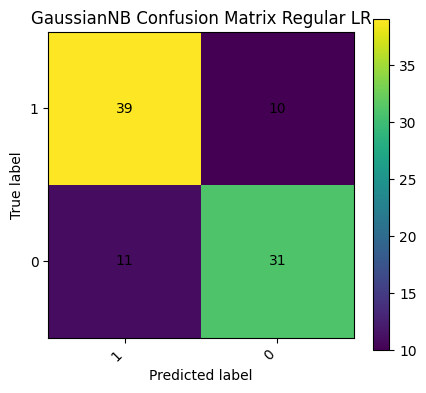

In [921]:
# Run model and get predictions

gaussNB = GaussianNB()
gaussNB.fit(X_train_gaussNB, y_train)
yhat_gaussNB = gaussNB.predict(X_test_gaussNB)

# Get metrics
print('Getting metrics...')
full_metrics_table = pd.DataFrame(classification_report(y_test, yhat_gaussNB, output_dict=True)).reset_index().rename(columns={'index':'metrics'})

metrics_totals = full_metrics_table[['metrics','macro avg','weighted avg']]
metrics_totals.insert(loc=0, column='model_type', value='GaussianNB')


metrics_by_target_level = full_metrics_table.iloc[:, :-3]
metrics_by_target_level.insert(loc=0, column='model_type', value='GaussianNB')

accuracy = round(full_metrics_table['accuracy'].max(), 4)

# Get confusion matrix
cm = confusion_matrix(y_test, yhat_gaussNB)
plot_confusion_matrix(cm, df['num'].unique(), title='GaussianNB Confusion Matrix')

models_accuracy_scores.loc[len(models_accuracy_scores.index)] = ['GaussianNB', 'n/a', accuracy]
metrics_totals_summary = pd.concat([metrics_totals_summary, metrics_totals])
metrics_by_target_level_summary = pd.concat([metrics_by_target_level_summary, metrics_by_target_level])


In [922]:
models_accuracy_scores

,model,alpha,accuracy
0,BernoulliNB,1.0,0.8352
1,BernoulliNB,0.01,0.8352
2,GaussianNB,n/a,0.7692


In [923]:
metrics_totals_summary

,model_type,metrics,macro avg,weighted avg
0,BernoulliNB_alpha = 1,precision,0.834060,0.835607
1,BernoulliNB_alpha = 1,recall,0.835034,0.835165
2,BernoulliNB_alpha = 1,f1-score,0.834445,0.835285
3,BernoulliNB_alpha = 1,support,91.000000,91.000000
0,BernoulliNB_alpha = 0.01,precision,0.834060,0.835607
1,BernoulliNB_alpha = 0.01,recall,0.835034,0.835165
2,BernoulliNB_alpha = 0.01,f1-score,0.834445,0.835285
3,BernoulliNB_alpha = 0.01,support,91.000000,91.000000
0,GaussianNB_Regular LR,precision,0.768049,0.768968
1,GaussianNB_Regular LR,recall,0.767007,0.769231


In [924]:
metrics_by_target_level_summary

,model_type,metrics,0,1
0,BernoulliNB_alpha = 1,precision,0.854167,0.813953
1,BernoulliNB_alpha = 1,recall,0.836735,0.833333
2,BernoulliNB_alpha = 1,f1-score,0.845361,0.823529
3,BernoulliNB_alpha = 1,support,49.000000,42.000000
0,BernoulliNB_alpha = 0.01,precision,0.854167,0.813953
1,BernoulliNB_alpha = 0.01,recall,0.836735,0.833333
2,BernoulliNB_alpha = 0.01,f1-score,0.845361,0.823529
3,BernoulliNB_alpha = 0.01,support,49.000000,42.000000
0,GaussianNB_Regular LR,precision,0.780000,0.756098
1,GaussianNB_Regular LR,recall,0.795918,0.738095


## b. Linear Regression

We will test the linear regression model on the dataset and extract key insights for best modle selection.

In [925]:
# Create the Linear Regression X datasets with standardized vars and encoded vars ( same as gaussian )
# We will exclude the categorical variable derived from continuous variables for this

X_train_LR = X_train[[i for i in included_num_vars if i not in exclude_num_vars]]
X_test_LR = X_test[[i for i in included_num_vars if i not in exclude_num_vars]]

print(X_train_LR.columns, X_train_LR.shape)
X_train_LR.head()

Index(['sex', 'fbs', 'exang', 'trestbps_category', 'cp=1', 'cp=2', 'cp=3',
       'cp=4', 'restecg=0', 'restecg=1', 'restecg=2', 'slope=1', 'slope=2',
       'slope=3', 'thal=-1.0', 'thal=3.0', 'thal=6.0', 'thal=7.0',
       'age_category=Middle adulthood', 'age_category=Old old age',
       'age_category=Young adulthood', 'age_category=Young old age',
       'chol_category=Borderline high', 'chol_category=High',
       'chol_category=Normal', 'oldpeak_category=(-0.001, 0.8]',
       'oldpeak_category=(0.8, 1.12]', 'oldpeak_category=(1.12, 1.4]',
       'oldpeak_category=(1.4, 1.9]', 'oldpeak_category=(1.9, 2.8]',
       'oldpeak_category=(2.8, 4.4]', 'thalach_category=(70.999, 116.0]',
       'thalach_category=(116.0, 130.0]', 'thalach_category=(130.0, 140.6]',
       'thalach_category=(140.6, 146.0]', 'thalach_category=(146.0, 153.0]',
       'thalach_category=(153.0, 159.0]', 'thalach_category=(159.0, 163.0]',
       'thalach_category=(163.0, 170.0]', 'thalach_category=(170.0, 176.6

,sex,fbs,exang,trestbps_category,cp=1,cp=2,cp=3,cp=4,restecg=0,restecg=1,restecg=2,slope=1,slope=2,slope=3,thal=-1.0,thal=3.0,thal=6.0,thal=7.0,age_category=Middle adulthood,age_category=Old old age,age_category=Young adulthood,age_category=Young old age,chol_category=Borderline high,chol_category=High,chol_category=Normal,"oldpeak_category=(-0.001, 0.8]","oldpeak_category=(0.8, 1.12]","oldpeak_category=(1.12, 1.4]","oldpeak_category=(1.4, 1.9]","oldpeak_category=(1.9, 2.8]","oldpeak_category=(2.8, 4.4]","thalach_category=(70.999, 116.0]","thalach_category=(116.0, 130.0]","thalach_category=(130.0, 140.6]","thalach_category=(140.6, 146.0]","thalach_category=(146.0, 153.0]","thalach_category=(153.0, 159.0]","thalach_category=(159.0, 163.0]","thalach_category=(163.0, 170.0]","thalach_category=(170.0, 176.6]","thalach_category=(176.6, 202.0]",age_std,trestbps_std,chol_std,thalach_std,oldpeak_std,ca_std,ca_miss_ind
122,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.381100,-1.803559,-0.490558,-0.289320,0.151619,-0.711131,0
98,1,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.270281,0.131482,-0.916109,0.367503,-0.204509,0.360873,0
170,1,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.724458,1.611220,0.461867,-1.646753,1.665163,0.360873,0
29,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.600107,-1.234430,-1.605097,-1.559176,0.863875,-0.711131,0
172,0,0,1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505451,2.408002,0.056580,-0.289320,-0.916765,-0.711131,0


In [926]:
y_test

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1])

This is the Regular LR run.
Getting metrics...


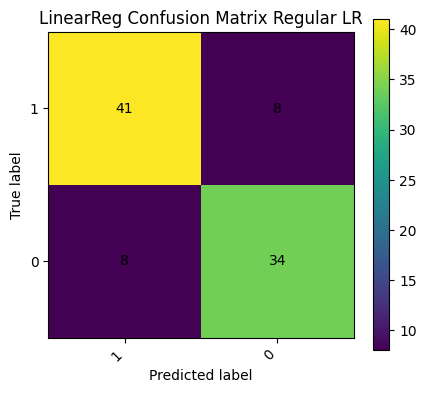

This is the Lasso run.
Getting metrics...


/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

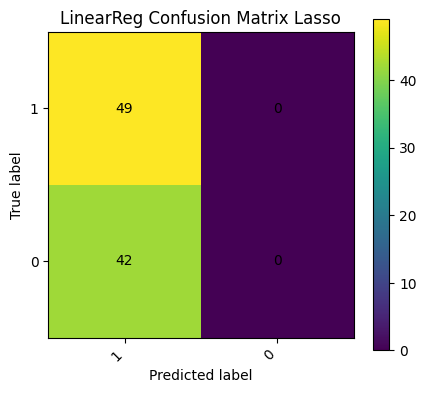

This is the Ridge run.
Getting metrics...


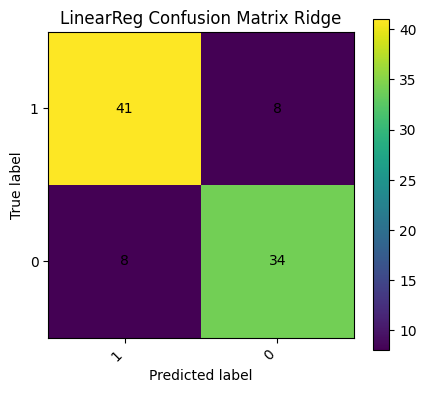

In [932]:
# Create a table for error metrics
error_metrics = pd.DataFrame(columns=['MSE','MAE', 'R2'])
coeff_table_summary = None

for penalization, alpha in alphasLR.items():
    print("This is the " + penalization + " run.")
    if penalization == "Lasso":
        LR = Lasso()
    elif penalization == "Ridge":
        LR = Ridge()
    else:
        LR = LinearRegression()

    LR.fit(X_train_LR, y_train)
    yhat_LR = LR.predict(X_test_LR)
    yhat_LR_class = np.round(yhat_LR).astype(int)

    # Get metrics
    print('Getting metrics...')

    # Error metrics
    mse = mean_squared_error(y_test, yhat_LR)
    mae = mean_absolute_error(y_test, yhat_LR)
    r2 = r2_score(y_test, yhat_LR)

    error_metrics.loc[len(error_metrics.index)] = [mse, mae, r2]

    # Retrieve coeff table
    coeff_table = pd.DataFrame({'Feature':LR.feature_names_in_, 'Coefficient': LR.coef_})
    coeff_table.loc[len(coeff_table.index)] = ['Intercept', LR.intercept_]
    coeff_table_summary = pd.concat([coeff_table_summary, coeff_table])

    # Use 0.5 threshold for comparison with classifiers
    yhat_LR_class = (yhat_LR >= 0.5).astype(int)

    full_metrics_table = pd.DataFrame(classification_report(y_test, yhat_LR_class, output_dict=True)).reset_index().rename(columns={'index':'metrics'})

    metrics_totals = full_metrics_table[['metrics','macro avg','weighted avg']]
    metrics_totals.insert(loc=0, column='model_type', value='LinearReg_' + penalization)


    metrics_by_target_level = full_metrics_table.iloc[:, :-3]
    metrics_by_target_level.insert(loc=0, column='model_type', value='LinearReg_' + penalization)

    accuracy = round(full_metrics_table['accuracy'].max(), 4)

    # Get confusion matrix
    cm = confusion_matrix(y_test, yhat_LR_class)
    plot_confusion_matrix(cm, df['num'].unique(), title='LinearReg Confusion Matrix '+penalization)

    models_accuracy_scores.loc[len(models_accuracy_scores.index)] = ['LinearReg', alpha, accuracy]
    metrics_totals_summary = pd.concat([metrics_totals_summary, metrics_totals])
    metrics_by_target_level_summary = pd.concat([metrics_by_target_level_summary, metrics_by_target_level])

In [933]:
models_accuracy_scores

,model,alpha,accuracy
0,BernoulliNB,1.0,0.8352
1,BernoulliNB,0.01,0.8352
2,GaussianNB,n/a,0.7692
3,LinearReg,0.5,0.8242
4,LinearReg,0.0,0.5385
5,LinearReg,1,0.8242


In [934]:
metrics_totals_summary

,model_type,metrics,macro avg,weighted avg
0,BernoulliNB_alpha = 1,precision,0.834060,0.835607
1,BernoulliNB_alpha = 1,recall,0.835034,0.835165
2,BernoulliNB_alpha = 1,f1-score,0.834445,0.835285
3,BernoulliNB_alpha = 1,support,91.000000,91.000000
0,BernoulliNB_alpha = 0.01,precision,0.834060,0.835607
1,BernoulliNB_alpha = 0.01,recall,0.835034,0.835165
2,BernoulliNB_alpha = 0.01,f1-score,0.834445,0.835285
3,BernoulliNB_alpha = 0.01,support,91.000000,91.000000
0,GaussianNB_Regular LR,precision,0.768049,0.768968
1,GaussianNB_Regular LR,recall,0.767007,0.769231


In [935]:
metrics_by_target_level_summary

,model_type,metrics,0,1
0,BernoulliNB_alpha = 1,precision,0.854167,0.813953
1,BernoulliNB_alpha = 1,recall,0.836735,0.833333
2,BernoulliNB_alpha = 1,f1-score,0.845361,0.823529
3,BernoulliNB_alpha = 1,support,49.000000,42.000000
0,BernoulliNB_alpha = 0.01,precision,0.854167,0.813953
1,BernoulliNB_alpha = 0.01,recall,0.836735,0.833333
2,BernoulliNB_alpha = 0.01,f1-score,0.845361,0.823529
3,BernoulliNB_alpha = 0.01,support,49.000000,42.000000
0,GaussianNB_Regular LR,precision,0.780000,0.756098
1,GaussianNB_Regular LR,recall,0.795918,0.738095


# Model Evaluation

In [ ]:
# We will create a AUC curve